In [1]:
import matplotlib.pyplot as plt
import src.RX as RX
import numpy as np
import cv2
import time


#### parameters that needs to be exhanged between the sender and the receiver #####
IP = "0.0.0.0"
PORT = 23422
            #  t1  t2  t3  t4  t5  t6  t7  t8  t9
X = np.array([[ 1,  0,  0,  0,  0,  0,  1,  0,  0], # m1
              [ 1,  0,  0,  0,  0,  0,  0,  1,  0], # m2
              [ 1,  0,  0,  0,  0,  0,  0,  0,  1], # m3
              [ 0,  1,  0,  0,  0,  0,  1,  0,  0], # m4
              [ 0,  1,  0,  0,  0,  0,  0,  1,  0], # m5
              [ 0,  1,  0,  0,  0,  0,  0,  0,  1], # m6
              [ 0,  0,  1,  0,  0,  0,  1,  0,  0], # m7
              [ 0,  0,  1,  0,  0,  0,  0,  1,  0], # m8
              [ 0,  0,  1,  0,  0,  0,  0,  0,  1], # m9
              [ 0,  0,  0,  1,  0,  0,  1,  0,  0], # m10
              [ 0,  0,  0,  1,  0,  0,  0,  1,  0], # m11
              [ 0,  0,  0,  1,  0,  0,  0,  0,  1], # m12
              [ 0,  0,  0,  0,  1,  0,  1,  0,  0], # m13
              [ 0,  0,  0,  0,  1,  0,  0,  1,  0], # m14
              [ 0,  0,  0,  0,  1,  0,  0,  0,  1], # m15
              [ 0,  0,  0,  0,  0,  1,  1,  0,  0], # m16
              [ 0,  0,  0,  0,  0,  1,  0,  1,  0], # m17
              [ 0,  0,  0,  0,  0,  1,  0,  0,  1]]) # m18
            #  t1  t2  t3  t4  t5  t6  t7  t8  t9
Y = np.array([[ 0,  0,  0,  0,  0,  0,  1,  0,  0], # m1
              [ 0,  0,  0,  0,  0,  0,  0,  1,  0], # m2
              [ 1,  0,  0,  0,  0,  0,  0,  0,  0], # m3
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m4
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m5
              [ 0,  1,  0,  0,  0,  0,  0,  0,  0], # m6
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m7
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m8
              [ 0,  0,  1,  0,  0,  0,  0,  0,  0], # m9
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m10
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m11
              [ 0,  0,  0,  1,  0,  0,  0,  0,  0], # m12
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m13
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m14
              [ 0,  0,  0,  0,  1,  0,  0,  0,  0], # m15
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m16
              [ 0,  0,  0,  0,  0,  1,  0,  0,  0], # m17
              [ 0,  0,  0,  0,  0,  0,  0,  0,  1]]) # m18

# X = np.eye(18)
# Y = np.eye(18)

chunk_size_Byte = 1024
key = b"key"
digestmod = 'sha384'



buffer = RX.Buffer(X, Y, BUFFER_SIZE_IN_PAGES = 25, TIMEOUT_SECOND = 0.00001,  warnings = True)
udp_rx = RX.UDP_RX(buffer= buffer, IP = IP, PORT = PORT, X = X, Y = Y,  chunk_size_Byte=chunk_size_Byte, KEY=key, digestmod=digestmod)

# verified_page = udp_rx.receive()
# rec, _, _ = udp_rx.process_verified_page(verified_page)
# 1/0
total_avg_verification = []
total_not_verified_cnt = []
tag_per_message_cnt = []
total_latency = []
cnt = 0

start = time.time()

while True:
    cnt += 1
    verified_page = udp_rx.receive()
    rec, avg_vericication, not_verified_cnt, tag_per_message, latency = udp_rx.process_verified_page(verified_page)
    total_avg_verification.append(avg_vericication)
    total_not_verified_cnt.append(not_verified_cnt)
    tag_per_message_cnt.append(tag_per_message)
    total_latency.append(latency)
    if rec is not None and len(rec) > 0:  # Ensure rec is not None and has valid data
        nparr = np.frombuffer(rec, np.uint8)
        
        if nparr is not None and len(nparr) > 0:  # Check if nparr is valid
            try:
                frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
                
                if frame is not None:  # Ensure that the frame is successfully decoded
                    cv2.imshow('Received Video', frame)
                    
                    if cv2.waitKey(1) & 0xFF == ord('q'):
                        break
                else:
                    # print("Failed to decode frame.")
                    pass
            except Exception as e:
                # print(f"Error decoding frame: {e}")
                pass
        else:
            # print("Empty or invalid buffer received.")
            pass
    else:
        # print("Received an empty or invalid page.")
        pass
    if cnt % 100 == 0:
        print(f"avg_verification: {np.sum(total_avg_verification)/cnt}, not_verified_cnt: {np.sum(total_not_verified_cnt)}, tag_per_message: {np.sum(tag_per_message_cnt)/cnt}, latency: {np.sum(total_latency)/cnt}")
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    if time.time() - start > 50:
        break
cv2.destroyAllWindows()

2024-08-30 21:05:03.930 Python[3415:66904] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.
Corrupt JPEG data: 20289 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 21452 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2027 extraneous bytes before marker 0xa7
Corrupt JPEG data: premature end 

avg_verification: 0.9699074074074073, not_verified_cnt: 1, tag_per_message: 1.9317069055036344, latency: -0.041946087132262784


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end 

avg_verification: 0.9749537037037037, not_verified_cnt: 1, tag_per_message: 1.9427185321168963, latency: -0.04249204747665148


Corrupt JPEG data: 322 extraneous bytes before marker 0xd9
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 16 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG d

avg_verification: 0.9666093474426809, not_verified_cnt: 2, tag_per_message: 1.9268188097710526, latency: -0.04058723756480902


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2542 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 66 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 676 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of dat

avg_verification: 0.9724570105820106, not_verified_cnt: 2, tag_per_message: 1.9384315676457498, latency: -0.04010357580640811


Corrupt JPEG data: 21578 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2555 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 1 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 159 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corru

avg_verification: 0.9779656084656085, not_verified_cnt: 2, tag_per_message: 1.9494531906245365, latency: -0.04033140420090088


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 49 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


avg_verification: 0.978289241622575, not_verified_cnt: 3, tag_per_message: 1.9502038097710526, latency: -0.04015924872680997


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 552 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2548 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2589 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 307 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5446 ext

avg_verification: 0.9785222978080121, not_verified_cnt: 4, tag_per_message: 1.9506689571280227, latency: -0.03966025024101816


Corrupt JPEG data: 2205 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 10 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2 extraneous bytes before mark

avg_verification: 0.9737070105820106, not_verified_cnt: 4, tag_per_message: 1.940789702566385, latency: -0.039286749503315


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4814 extraneous bytes before marker 0xd9
Corrupt JPEG data: 111 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2460 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 33184 extraneous bytes before marker 0xd9
Corrupt JPEG data: 33018 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


avg_verification: 0.9755085243974133, not_verified_cnt: 5, tag_per_message: 1.9439060495475446, latency: -0.039088115513815865


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 10 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3196 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG 

avg_verification: 0.977957671957672, not_verified_cnt: 5, tag_per_message: 1.9488583017356476, latency: -0.03898855537292869


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end 

avg_verification: 0.9772342472342473, not_verified_cnt: 5, tag_per_message: 1.9472499712748315, latency: -0.038620931532304295


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 32989 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 222 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2358 extraneous bytes before marker 0xc4
Corrupt JPEG data: 800 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


avg_verification: 0.9757980599647268, not_verified_cnt: 5, tag_per_message: 1.9442546032982246, latency: -0.03836790742758026


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3117 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 174 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG

avg_verification: 0.9738135938135939, not_verified_cnt: 5, tag_per_message: 1.940213650907763, latency: -0.038015220216585356


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 20651 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


avg_verification: 0.9721126228269087, not_verified_cnt: 5, tag_per_message: 1.9369444218746688, latency: -0.03787765013072352


Corrupt JPEG data: premature end of data segment


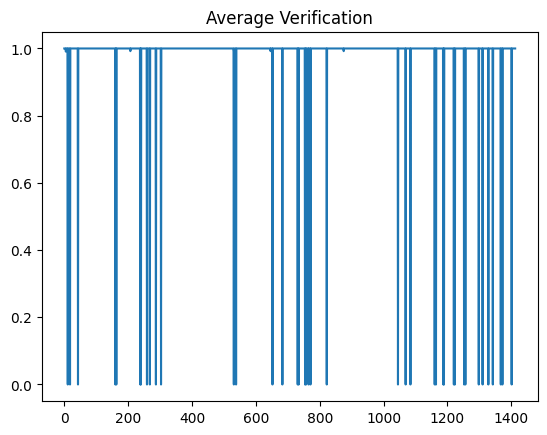

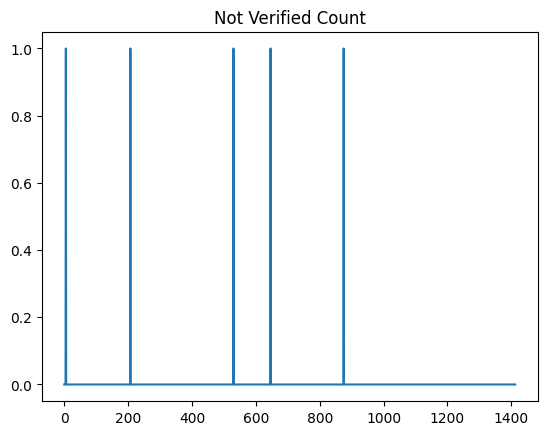

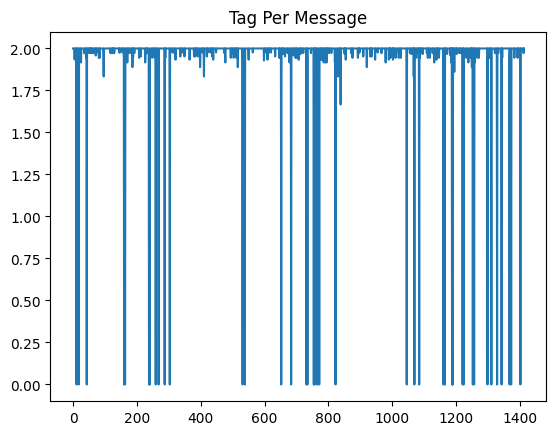

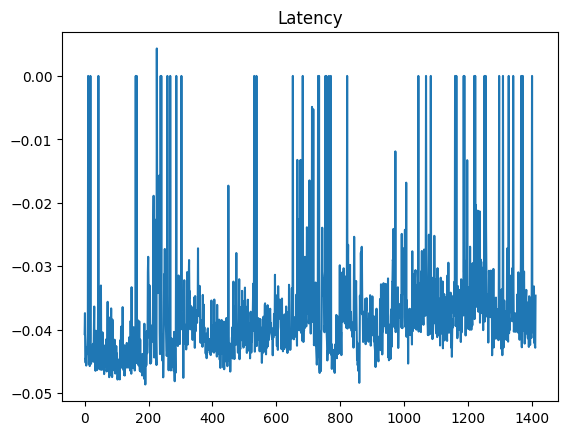

In [2]:

plt.plot(total_avg_verification)
plt.title('Average Verification')
plt.show()

plt.plot(total_not_verified_cnt)
plt.title('Not Verified Count')
plt.show()

plt.plot(tag_per_message_cnt)
plt.title('Tag Per Message')
plt.show()

plt.plot(total_latency)
plt.title('Latency')
plt.show()